In [1]:
# cargamos las librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential


In [2]:
from keras.layers import LSTM
from keras.layers import Dense

In [3]:
# esta celda sirve para dar permiso al accedo de tus archivos del gdrive
link ='https://docs.google.com/spreadsheets/d/e/2PACX-1vTRmmsm3qKHPv04W2q5Vp57bVLa6tc706boLNhS7mVtH1hh4gpkAfRT7d1XsQYd1g/pub?gid=145097224&single=true&output=csv'

In [4]:
df = pd.read_csv(link)
df.head()

,timestamp,demand
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [5]:
# colocar el campo fecha como indice

df = df.set_index('timestamp')
df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
df.shape

(105, 1)

In [7]:
# seleccionamos las variables de interés

dataset = df.values

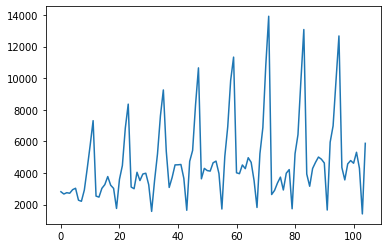

In [8]:
# redimensionando la variable en vector columna reshape (-1,1)
# luego se plotea

dataset = dataset.reshape(-1,1)
plt.plot(dataset)

Escalado de características

In [9]:
# escalando datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

Creando los conjuntos de entrenamiento y testing

In [10]:
# train_test_split

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
print(train.shape, test.shape)

(84, 1) (21, 1)


Crear la función que transforma el vector de la serie en una matriz (equivale al time generator)

In [12]:
# función que convierte a array

def to_sequences(dataset, seq_size = 1):
    x=[]
    y=[]
    
    for i in range(len(dataset) - seq_size-1):
        window = dataset[i:(i+seq_size),0]
        x.append(window)
        y.append(dataset[i+seq_size,0])
    
    return np.array(x),np.array(y)

Utilizamos la función en la data train - test

In [13]:
# seq_size es el número de columnas que tendrá la matriz : timesteps

seq_size = 12

trainX, trainY = to_sequences(train,seq_size)
testX, testY = to_sequences(test,seq_size)

In [14]:
# verificamos las dimensiones de tabla plana

print(trainX.shape)
print(testX.shape)

(71, 12)
(8, 12)


Convertimos las tablas planas a tensores 3D

In [15]:
# redimensionando los inputs para la CNN
# la tercera dimensión indic 1 por ser una serie univariante
# reshape from [samples, timesteps] into [samples, timesteps, features]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

print(trainX.shape, testX.shape)

(71, 12, 1) (8, 12, 1)


In [16]:
# Creando la red neuronal
# input_shape (columnas, características)
# define model

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape=(seq_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')

Entrenando la red LSTM

In [17]:
EPOCHS = 100
bs = seq_size

history = model.fit(trainX,trainY,epochs=EPOCHS,validation_data=(testX,testY), verbose = 1, batch_size = bs)

Epoch 1/100
6/6 [==============================] - 10s 509ms/step - loss: 0.0739 - val_loss: 0.0088
Epoch 2/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0460 - val_loss: 0.0570
Epoch 3/100
6/6 [==============================] - 0s 46ms/step - loss: 0.0432 - val_loss: 0.0174
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0394 - val_loss: 0.0110
Epoch 5/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0412 - val_loss: 0.0119
Epoch 6/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0410 - val_loss: 0.0189
Epoch 7/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0395 - val_loss: 0.0187
Epoch 8/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0396 - val_loss: 0.0193
Epoch 9/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0389 - val_loss: 0.0148
Epoch 10/100
6/6 [==============================] - 0s 48ms/step - loss: 0.0388 - val_loss: 0.0160
Epoch 11/100
6/6 

Text(0.5, 1.0, 'ECM vs. epochs')

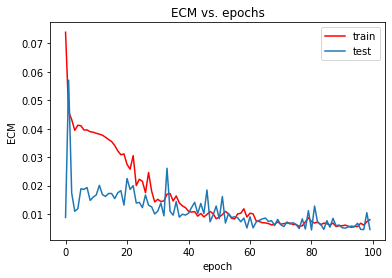

In [18]:
# ECM error cuadrático medio

plt.plot(history.history['loss'],color = 'r', label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('epoch')
plt.ylabel('ECM')
plt.legend(loc = 'best')
plt.title('ECM vs. epochs')

In [19]:
# predicciones escaladas

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# para obtener los valores originales le aplicamos la inversa del escalamiento

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [20]:
# preparando data para el plot

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

# shift test predictions 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1:] = testPredict

Plot entrenamiento, predicciones test , vs data real preparada en la celda anterior

<function matplotlib.pyplot.show>

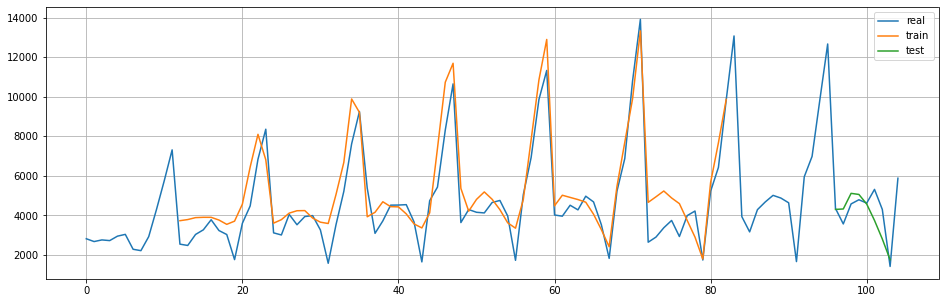

In [21]:
plt.figure(figsize=(16,5))

plt.plot(scaler.inverse_transform(dataset), label ='real')
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend(loc = 'best')
plt.grid()
plt.show

Pronóstico

In [22]:
# data de test tiene 3 dimensiones

testX.shape

(8, 12, 1)

In [23]:
# el último registro de la data de test

testX, testY = to_sequences(test,seq_size)
testX = testX[-1,:].reshape(-1,12)
testX.shape

(1, 12)

In [24]:
# convierto a 3D la data de test

x_test = testX.reshape((testX.shape[0], testX.shape[1],1))
x_test.shape

(1, 12, 1)

In [25]:
# con esto lleno la matriz de huecos para seguir calculando los puntos configurados en la variable parametro
# puedes mover el parametro para hacer pronóstico de más o menos puntos

parametro = 24

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0] = nuevoValor
    return x_test

results = []
for i in range(parametro):
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test,parcial[0])

[[[0.01967528]
  [0.3629529 ]
  [0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]]]
[[[0.3629529 ]
  [0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.02716171]]]
[[[0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.02716171]
  [0.33377934]]]
[[[0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.02716171]
  [0.33377934]
  [0.46494555]]]
[[[0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.02716171]
  [0.33377934]
  [0.46494555]
  [0.6229447 ]]]
[[[0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]


In [26]:
# valores inversos al escalado

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[ 1752.60286607],
       [ 5586.24301454],
       [ 7226.21427198],
       [ 9201.67775819],
       [12979.16575171],
       [ 4768.01241867],
       [ 4665.89782577],
       [ 5365.50608662],
       [ 5122.22425262],
       [ 4532.66735744],
       [ 3843.11811768],
       [ 2751.2374713 ],
       [ 1443.03013897],
       [ 4815.15386794],
       [ 6417.90352421],
       [ 8202.71455008],
       [11540.95992696],
       [ 6047.96868258],
       [ 6271.96005996],
       [ 6555.2111835 ],
       [ 5492.6673458 ],
       [ 4450.66596267],
       [ 3669.4574308 ],
       [ 3028.95632886]])

In [27]:
# concatenar df

df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [28]:
y_pred = pd.DataFrame(inverted)
len(y_pred)

24

Concatenamos los valores que ya teniamos con las predicciones

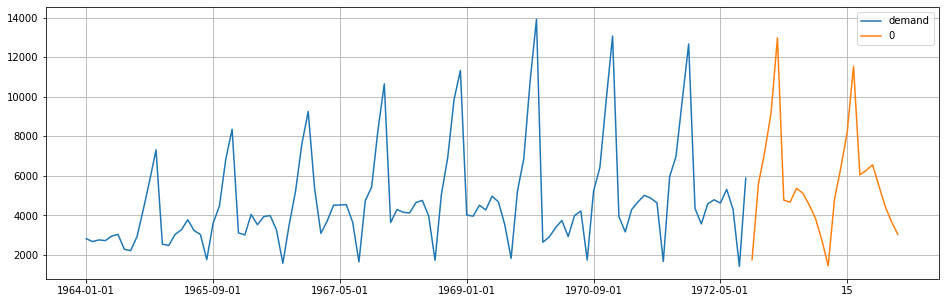

In [29]:
df2 = pd.concat([df,y_pred])
df2.plot(figsize=(16,5))
plt.grid()